In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/luad.PD1.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.PD1_data
0,20.896096,9.596848,2.621136,6.091040,26.987136,7222.344601,5542.944608,4488.941632,7340.434434,6629.914323,...,363.247141,404.190333,726.488530,1033.156899,546.149099,60.633336,154.321502,199.473325,91.969744,0
1,33.297296,27.611440,2.688688,16.676464,49.973760,6827.908140,5818.064608,4838.977306,6909.248278,6038.370282,...,684.119026,187.883124,441.737193,758.014409,378.138447,342.370143,628.942207,671.725133,452.277355,0
2,16.196352,14.338432,5.292528,7.572624,23.768976,6421.250695,6239.398856,4833.440739,7046.967885,6479.620220,...,2280.914415,626.684330,1043.768245,1362.935754,861.248713,660.148656,840.538212,844.357253,718.836184,1
3,21.409056,7.647860,3.045184,3.017804,24.426860,7203.461019,5575.010000,2588.072893,7297.514648,6716.384490,...,260.328180,165.397297,465.228181,869.175069,252.345164,153.953542,338.395316,402.610640,184.673757,0
4,45.594784,11.333904,9.456400,3.525824,49.120608,6754.013440,4663.890074,4092.977594,7066.696147,6273.346550,...,153.031493,29.016477,141.875209,389.412517,54.885314,60.730631,167.815079,337.793378,80.617895,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,23.765936,57.329956,3.801792,72.332320,96.098256,6195.865412,6565.996038,5996.931267,6390.584961,5958.308663,...,2040.234736,139.569508,464.085477,686.387496,551.154643,267.525756,659.271394,828.661378,689.887650,1
291,63.962976,119.120184,26.983584,150.687472,214.650448,6459.409250,6545.221751,5078.486560,6529.722708,6316.402076,...,734.067883,295.764850,317.024359,423.207047,385.230969,207.291793,413.137374,771.809351,603.590634,0
292,1.333536,3.458368,1.725584,110.496016,111.829552,2268.824304,3221.368807,5159.867289,5058.554594,1519.343410,...,14784.696625,374.193123,671.414956,1084.030034,1075.565428,179.222758,511.512945,430.232706,427.239483,0
293,35.620352,35.469832,25.362688,23.217568,58.837920,5833.738689,6248.578618,5167.807759,5772.045809,5422.754758,...,773.905672,280.541866,288.160372,496.132928,365.614556,54.238655,206.739068,371.572079,179.459097,0


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,-0.725939,-1.067297,-0.574697,-1.075333,-1.061052,0.971899,-0.831693,-1.320571,1.093752,1.089025,...,-0.684790,-0.611539,0.918176,2.126561,1.736157,0.626086,-0.588562,-1.034515,-1.156292,-1.122555
1,-0.466528,-0.762343,-0.571913,-0.872441,-0.792460,0.529441,-0.515896,-0.940149,0.464119,0.466857,...,-0.349545,-0.349995,-0.104656,0.623191,0.690197,-0.089754,1.392083,0.332143,-0.324928,-0.163208
2,-0.824250,-0.987030,-0.464626,-1.046935,-1.098656,0.073275,-0.032267,-0.946167,0.665222,0.930950,...,1.546558,0.951560,1.970263,3.801667,2.989819,1.968624,3.626106,0.941429,-0.021022,0.546525
3,-0.715209,-1.100290,-0.557225,-1.134238,-1.090969,0.950716,-0.794886,-3.386449,1.031079,1.179972,...,-0.842536,-0.695429,-0.210983,0.747214,1.112777,-0.625719,0.067490,-0.504479,-0.798684,-0.875723
4,-0.209286,-1.037892,-0.293060,-1.124501,-0.802429,0.446550,-1.840716,-1.750908,0.694030,0.713998,...,-0.811424,-0.782887,-0.855875,-0.959957,-0.711051,-1.467032,-0.587878,-0.995660,-0.912790,-1.152780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,-0.665907,-0.259262,-0.526050,0.194320,-0.253507,-0.179550,0.342618,0.318324,-0.293252,0.382650,...,0.529503,0.755381,-0.333113,0.741181,0.417906,0.647413,0.865918,0.419476,-0.048653,0.469447
291,0.174944,0.786733,0.429122,1.696162,1.131744,0.116079,0.318772,-0.679849,-0.090078,0.759282,...,-0.665554,-0.309281,0.405474,-0.035242,-0.582580,-0.059535,0.442465,-0.289261,-0.148737,0.239675
292,-1.135154,-1.171210,-0.611597,0.925808,-0.069691,-4.584693,-3.496516,-0.591404,-2.238330,-4.286124,...,9.352666,11.143445,0.776331,1.835795,1.929552,2.881759,0.245136,-0.005991,-0.750058,-0.229874
293,-0.417934,-0.629314,0.362335,-0.747067,-0.688884,-0.585764,-0.021730,-0.582774,-1.196465,-0.180630,...,-0.169347,-0.276810,0.333490,-0.187632,-0.305351,-0.143114,-0.633518,-0.883580,-0.853325,-0.889608


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

136


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/LUAD.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,1
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,20
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,1


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

98 98
98 98
99 99
0.45918367346938777
0.45918367346938777
0.46464646464646464


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(196, 607) (196,)
(99, 607) (99,)


In [46]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 20
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6971861471861472, 0.6981962481962483, 0.7018037518037519, 0.7033910533910535, 0.7138528138528139, 0.7144540644540645, 0.7223665223665223, 0.7218614718614719, 0.7261904761904763, 0.7348725348725349, 0.7311447811447812, 0.7386002886002886, 0.7414862914862915, 0.7443722943722944, 0.7323713323713325, 0.7247474747474747, 0.7567340067340067, 0.7765031265031265, 0.5486772486772487, 0.5]


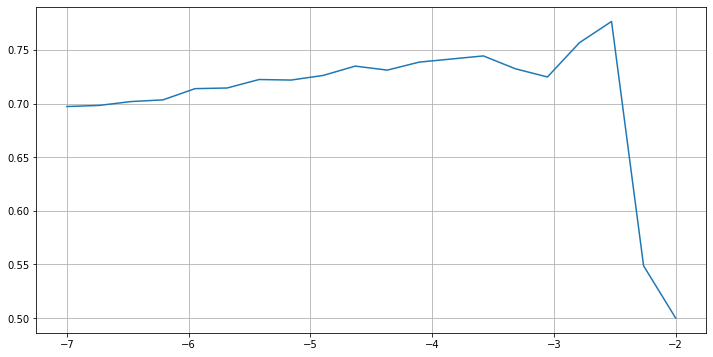

0.0799530421736451 -2.526315789473684


In [49]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.8
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

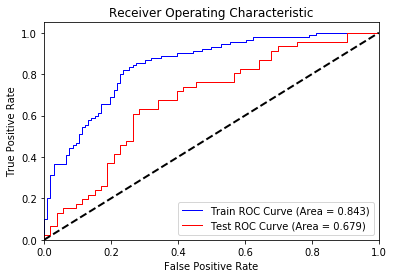

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

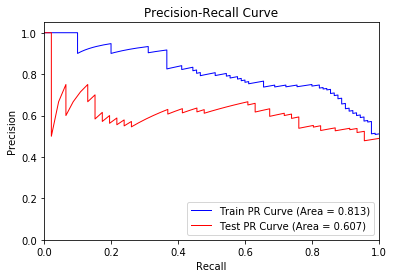

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 172


,HIF,Beta,Cluster
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.495231,13
479,REGION PROPERTIES: LACUNARITY OF STROMA_HE,0.459726,6
511,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF STROMA_HE,0.241283,6
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.205591,13
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.204104,1
...,...,...,...
573,TOTAL [CANCER CELLS] IN [EPITHELIAL] SELECTED BY [MACROPHAGE_RADIUS_80]_HE,-0.136344,1
222,COUNT PROP [LYMPHOCYTE CELLS] IN [[TUMOR] OVER [ESI_0080]]_HE,-0.150684,5
79,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT STANDARD DEVIATION OF LYMPHOCYTE IN TUMOR_HE,-0.155638,6
427,REGION PROPERTIES: AVERAGE EXTENT OF SIGNIFICANT REGIONS OF ESI_0080_HE,-0.186710,18


### Outer Loop 2

In [13]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(197, 607) (197,)
(98, 607) (98,)


In [ ]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.646564244165378, 0.6582264337705966, 0.6790054424625394, 0.6952823103858938, 0.7000186914538119, 0.7273633163138342, 0.7166800534136761, 0.7418002008567519, 0.7238383525302619, 0.7530459570913097, 0.6617265126468654, 0.7043866592456318, 0.7242248462468227, 0.72003437783288, 0.7499456753586093, 0.7641033823477132, 0.7179063849784034, 0.7573682377486269, 0.5, 0.5]


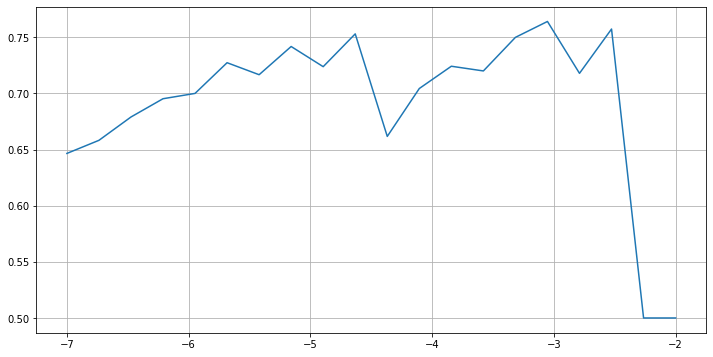

0.047234459484186364 -3.0526315789473686


In [50]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

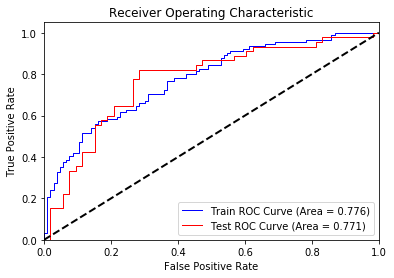

In [15]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

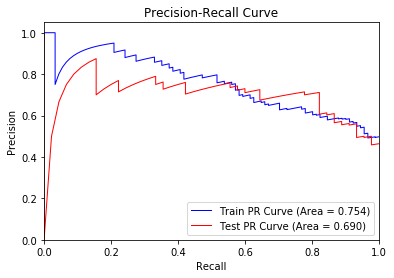

In [16]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 46


,HIF,Beta,Cluster
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.390493,13
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.359125,13
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.238988,13
477,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF TUMOR_HE,0.187204,4
435,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF TUMOR_HE,0.132915,4
114,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.128926,13
480,REGION PROPERTIES: LACUNARITY OF TUMOR_HE,0.090569,4
115,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN TUMOR_HE,0.079140,13
175,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN TUMOR_HE,0.045156,13
188,COUNT PROP [CANCER CELLS] IN [[EPITHELIAL] OVER [ESI_0080]]_HE,0.016078,4


### Outer Loop 3

In [18]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(197, 607) (197,)
(98, 607) (98,)


In [ ]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

In [ ]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.9
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

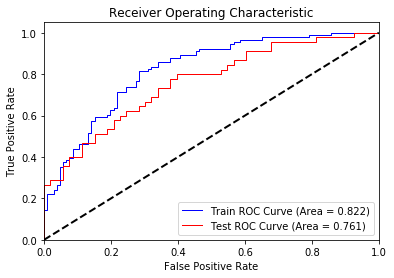

In [20]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

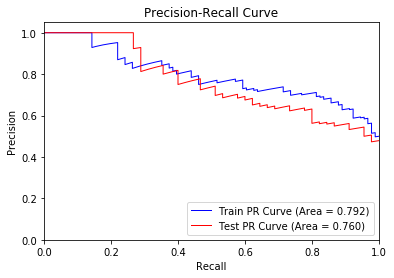

In [21]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 129


,HIF,Beta,Cluster
479,REGION PROPERTIES: LACUNARITY OF STROMA_HE,0.640855,6
435,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF TUMOR_HE,0.495475,4
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.494956,13
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.390460,13
455,REGION PROPERTIES: EXTENT OF LARGEST REGION OF TUMOR_HE,0.203912,4
...,...,...,...
537,REGION PROPERTIES: STANDARD DEVIATION OF SOLIDITIES OF SIGNIFICANT REGIONS OF ESI_0080_HE,-0.079565,4
48,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF CANCER IN EPITHELIAL_HE,-0.087232,5
27,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF PLASMA IN TUMOR_HE,-0.145807,6
405,DENSITY [LYMPHOCYTE CELLS] IN [ESI_0080]_HE,-0.157490,8


## Compute Ensemble Model

In [23]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.495231,0.390493,0.494956,13,0.460227
479,REGION PROPERTIES: LACUNARITY OF STROMA_HE,0.459726,0.000000,0.640855,6,0.366860
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.185526,0.238988,0.390460,13,0.271658
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.205591,0.359125,0.195266,13,0.253327
435,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF TUMOR_HE,0.015827,0.132915,0.495475,4,0.214739
...,...,...,...,...,...,...
431,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,0.000000,-0.187959,0.000000,18,-0.062653
271,COUNT PROP [[[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,-0.226324,0.000000,0.000000,13,-0.075441
266,COUNT PROP [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [STROMA]_HE,0.000000,0.000000,-0.239383,8,-0.079794
427,REGION PROPERTIES: AVERAGE EXTENT OF SIGNIFICANT REGIONS OF ESI_0080_HE,-0.186710,-0.307721,0.000000,18,-0.164810


## Compute Final Train / Test Metrics

In [24]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.8433962264150943, 0.7763839933651253, 0.8218950860460295]
0.8138917686087496 0.027936829479944424


In [25]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.679245283018868, 0.771488469601677, 0.7614255765199162]
0.7373864430468204 0.04131675464296711


In [26]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.8128714217821948, 0.7540343217121962, 0.7920035000793637]
0.7863030811912516 0.024356000872977453


In [27]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.6070977703772822, 0.6901362665314645, 0.7603691698159444]
0.685867735574897 0.06264554114948041


## Evaluate Hold-Out Set

In [28]:
holdout_df = pd.read_csv("{0}/data/genetic_data/PanImmune/datasets/luad.PD1.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.PD1_data
0,136.661136,159.244844,13.627104,124.760496,261.421632,6569.555773,6196.871210,5883.111381,6845.927703,6511.041537,...,324.892777,267.874255,300.876303,400.311009,331.078187,183.841586,300.662796,435.233922,303.815715,1
1,39.920912,69.314676,5.315152,64.545840,104.466752,6519.085240,6684.527789,6467.939404,6743.460348,5011.467504,...,617.804218,121.064368,412.986133,855.887847,575.082491,65.679862,750.461562,1296.954227,826.435190,1
2,62.302536,129.819836,5.933816,178.632208,240.934744,6336.653660,6287.289649,6727.715056,6762.129199,5006.195021,...,2372.671498,189.446542,488.607920,856.816370,684.243365,193.988893,762.133146,877.585301,700.816317,1
3,74.309088,125.439476,12.137280,166.299872,240.608960,5699.687863,6511.093987,5531.920743,6012.873158,5063.523013,...,1480.244127,152.282854,428.031125,747.120238,563.412102,139.242726,794.143942,828.449225,615.596360,0
4,67.641900,95.316000,31.037048,54.533612,122.175512,6456.923068,6873.572132,6193.082487,6650.332045,6189.983149,...,288.895863,22.826089,167.254186,433.604141,206.178796,65.211060,129.254270,236.276299,141.566831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,16.295424,22.866624,3.175088,12.735248,29.030672,7410.985019,7204.818710,6976.726907,7460.400035,6296.664491,...,1199.455528,171.459178,442.347764,909.601446,495.269279,155.994714,654.316090,1670.481800,820.373707,1
91,96.848160,54.131324,13.223424,21.179504,118.027664,7320.798988,6005.536544,5830.458945,7213.837199,5145.353655,...,80.260845,8.311980,69.811705,433.060189,84.531030,3.851390,37.187341,143.251702,28.866114,1
92,8.241392,11.694380,6.631776,10.866672,19.108064,5981.225129,6573.416890,5682.214054,6185.403365,5174.081836,...,706.350994,295.702474,491.518148,810.551749,588.494994,248.259032,1005.183687,1339.048423,868.586163,1
93,3.746672,8.019604,2.764032,10.716912,14.463584,6380.083503,6371.211659,6912.881810,6738.488914,6184.440881,...,355.928378,111.031870,167.963406,228.610630,198.152823,185.231053,463.863303,493.705650,413.797853,0


In [29]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,3.614228,3.170403,0.706686,2.806389,3.533173,0.251646,-0.282006,-0.245824,0.457786,1.405122,...,-1.174405,-0.947738,-0.012583,-0.494030,-1.080854,-0.681668,0.057461,-0.684984,-0.786190,-0.689770
1,0.374051,0.818779,-0.184282,1.010980,0.788277,0.169756,0.488734,0.556413,0.267472,-0.808721,...,-0.524716,-0.372168,-0.795462,0.052918,0.587577,0.412935,-0.705311,0.247270,0.332202,0.499387
2,1.123692,2.400956,-0.117967,4.412672,3.174889,-0.126245,-0.139100,0.912760,0.302146,-0.816505,...,2.187105,3.076138,-0.430807,0.421852,0.590977,0.902630,0.122965,0.271460,-0.212080,0.213557
3,1.525835,2.286412,0.546990,4.044961,3.169192,-1.159741,0.214622,-0.727570,-1.089456,-0.731871,...,0.850254,1.322522,-0.628986,0.126317,0.189244,0.360582,-0.230439,0.337806,-0.275852,0.019649
4,1.302527,1.498699,2.572879,0.712447,1.097976,0.068896,0.787519,0.179378,0.094503,0.931139,...,-1.043747,-1.018471,-1.319328,-1.145929,-0.958927,-1.241966,-0.708337,-1.040246,-1.044409,-1.058948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,-0.417251,-0.395812,-0.413678,-0.533847,-0.530982,1.616890,1.311053,1.254342,1.599052,1.088634,...,1.118986,0.770774,-0.526727,0.196164,0.784289,0.054893,-0.122300,0.047999,0.816988,0.485595
91,2.280749,0.421743,0.663415,-0.282066,1.025437,1.470560,-0.584410,-0.318050,1.141108,-0.611063,...,-1.259716,-1.428438,-1.396726,-1.621319,-0.960919,-1.787678,-1.104434,-1.231064,-1.165142,-1.315385
92,-0.687009,-0.687960,-0.043152,-0.589562,-0.704512,-0.702938,0.313124,-0.521405,-0.769014,-0.568651,...,-0.395702,-0.198174,0.135814,0.436050,0.421545,0.473103,0.473296,0.775208,0.386834,0.595297
93,-0.837554,-0.784053,-0.457740,-0.594027,-0.785737,-0.055779,-0.006461,1.166763,0.258238,0.922957,...,-1.190462,-0.886753,-0.848962,-1.142469,-1.709662,-1.277971,0.066430,-0.346734,-0.710302,-0.439519


In [30]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

49


In [31]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [32]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

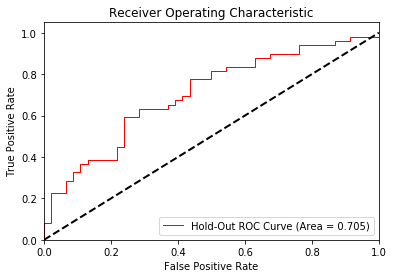

In [33]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.705


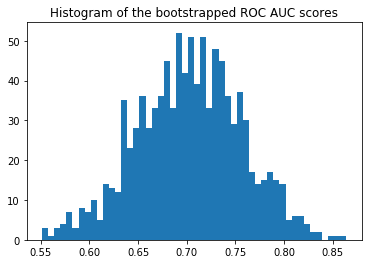

Confidence interval for the score: [0.593 - 0.805]


In [34]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

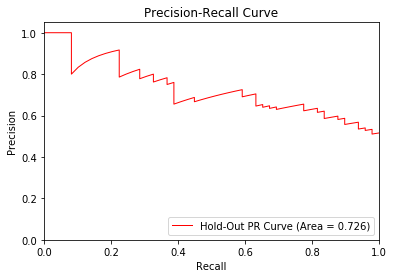

In [35]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.726


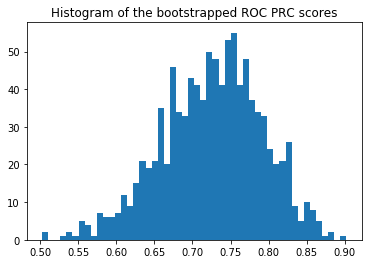

Confidence interval for the score: [0.587 - 0.849]


In [36]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))